In [1]:
import soundfile
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.nn import functional as F
from hybra import utils
import scipy.linalg

from hybra.utils import calculate_condition_number, fir_tightener3000, fir_tightener4000, random_filterbank, smooth_fir

In [2]:
def fb_analysis(w, D):
    N = w.shape[1]
    J = w.shape[0]
    w = w.flip((1,)).roll(1, 1)
    W = torch.cat([w.flip((1,)), torch.narrow(w.flip((1,)), dim=1, start=0, length=N-1)], dim=1)
    W = W.unfold(1, N, 1).flip((-1,)).reshape(J*N, N)
    return torch.conj(W[::D, :])

In [3]:
def frame_bounds_polyphase(w, D):
    """
    in: frequency responses of fb (system length, n_filters), decimation factor
    out: frame bounds
    """
    N = w.shape[0]
    M = w.shape[1]
    assert N % D == 0

    A = torch.inf
    B = 0
    Ha = torch.zeros((D,M))
    Hb = torch.zeros((D,M))

    for j in range(N//D):
        idx_a = np.mod(j - np.arange(D) * (N//D), N).astype(int)
        idx_b = np.mod(np.arange(D) * (N//D) - j, N).astype(int)
        Ha = w[idx_a, :]
        Hb = torch.conj(w[idx_b, :])
        lam = torch.linalg.eigvalsh(Ha @ Ha.H + Hb @ Hb.H).real
        A = np.min([A, torch.min(lam).item()]).item()
        B = np.max([B, torch.max(lam).item()]).item()
    return A/D, B/D
    
def calculate_condition_number(w, D):
    """
    in: frequency responses of fb (system length, n_filters), decimation factor
    out: condition number
    """
    A, B = frame_bounds_polyphase(w, D)
    return B/A

In [153]:
def can_tight_polyphase(w, D):
    """
    in: frequency responses of fb (system length, n_filters), decimation factor
    out: frequency responses of can tight fb
    """
    if D == 1:
        lp = torch.sum(w.abs() ** 2, dim=1)
        w_tight = w * lp ** (-0.5)
        return w_tight
    else:
        N = w.shape[0]
        M = w.shape[1]
        w_tight = torch.zeros(M, N, dtype=w.dtype)
        for j in range(N//D):
            idx = np.mod(j - np.arange(D) * (N//D), N).astype(int)
            H = w[idx, :]
            U, S, V = torch.linalg.svd(H, full_matrices=False)
            H = U @ V
            w_tight[:,idx] = H.T
        return torch.fft.ifft(w_tight.T, dim=1) * np.sqrt(D)

In [154]:
def fir_tightener5000(w, supp, D=1, eps=1.01):
    """
    Iterative tightening procedure with fixed support for a given filterbank 
    :param w: analysis filterbank
    :param supp: desired support of the tight filterbank
    :param eps: desired precision for kappa = B/A
    :return: approximately tight filterbank only on support: ready to use for conv1d
    """
    W = torch.fft.fft(w.T, dim=0)
    kappa = calculate_condition_number(W, D)
    w_tight = W.clone()
    while kappa > eps:
        w_tight = can_tight_polyphase(w_tight, D)
        w_tight = torch.fft.ifft(w_tight.T, dim=1)
        w_tight[:, supp:] = 0
        w_tight = torch.fft.fft(w_tight.T, dim=0)
        kappa = calculate_condition_number(w_tight, D)
        print(kappa)
    return torch.fft.ifft(w_tight.T, dim=1)[:, :supp]

In [155]:
def fir_tightener4000(w, supp, eps=1.01):
    """
    Iterative tightening procedure with fixed support for a given filterbank
    :param w: analysis filterbank
    :param supp: desired support of the tight filterbank
    :param eps: desired precision for kappa = B/A
    :return: approximately tight filterbank, where every filter is additionally a tight filterbank
    """
    for i in range(w.shape[0]):
        filter = w[i,:].reshape(1,-1)
        w[i,:] = fir_tightener3000(filter, supp, eps)
    return w

In [211]:
def kappa_alias(w, D):
    w_hat = torch.fft.fft(w.T, dim=0)
    kappa = calculate_condition_number(w_hat, D)

    if D == 1:
        return kappa, torch.tensor(0)
    else:
        N = w.shape[1]
        # W = fb_analysis(w, D) # this is still slow
        # S_hat = torch.fft.fft(W.H, dim=0) @ torch.fliplr(torch.fft.fft(W, dim=1)).roll(1,-1)
        # alias = torch.zeros(1,N)
        # for j in range(1,D):
        #     alias += torch.tensor([torch.abs(S_hat)[k,np.mod(k + j * N//D, N)].item() for k in range(0,N)]).reshape(1,-1)
        alias = torch.zeros_like(w_hat)
        for j in range(1,D):
            alias += w_hat * torch.conj(w_hat.roll(j * N//D, 0))
        alias = torch.sum(alias, dim=1)
    return kappa, torch.linalg.norm(alias).item()

4.927361098389923
[0 3] tensor([[ 0.5432+0.j,  0.0595+0.j],
        [ 0.5245+0.j, -0.9528+0.j],
        [ 0.6556+0.j, -0.2977+0.j]])
tensor(3.6753)
tensor(2.4502)


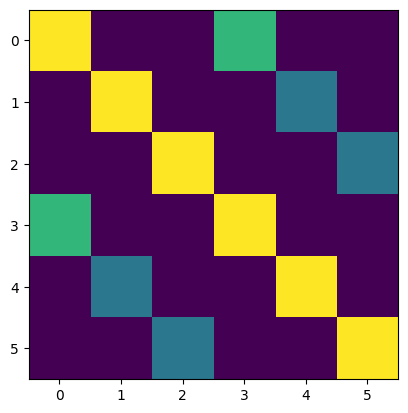

In [165]:
N_int = 6
J_int = 3
D_int = 2
w_int = torch.randint(1,10,(J_int,N_int))
w_int = fir_tightener3000(w_int, N_int, 1.01)
w_hat = torch.fft.fft(w_int, dim=1)
print(calculate_condition_number(w_hat.T, D_int))

W = fb_analysis(w_int, D_int)
S_hat = torch.fft.fft(W.H, dim=0) @ torch.fliplr(torch.fft.fft(W, dim=1)).roll(1,-1)
#print(S_hat)
plt.imshow(S_hat.abs())
alias = torch.zeros(1,N_int)
for j in range(1,D_int):
    alias += torch.tensor([torch.abs(S_hat)[k,np.mod(k + j * N_int//D_int, N_int)].item() for k in range(0,N_int)]).reshape(1,-1)

idx = np.mod(j - np.arange(D_int) * (N_int//D_int), N_int).astype(int)-1
H = w_hat[:,idx]
print(idx, H)

print(torch.linalg.norm(torch.cat((torch.diag(S_hat, 3),torch.diag(S_hat, -3)), dim=-1)))
print(torch.linalg.norm(torch.sum(w_hat * torch.conj(w_hat.roll(N_int//D_int, 1)),0)*2))

In [8]:
# def frame_bounds(w, D=1):
#     if D == 1:
#         w_hat = torch.sum(torch.fft.fft(w, dim=1).abs() ** 2, dim=0)
#         B = torch.max(w_hat).item()
#         A = torch.min(w_hat).item()
#     else:
#         W = fb_analysis(w, D)
#         S = W.H @ W
#         lam, _ = torch.linalg.eig(S)
#         B = torch.max(lam.real).item()
#         A = torch.min(lam.real).item()
#     return A, B

# def can_tight(w, D=1):
#     if D == 1:
#         w_freqz = torch.fft.fft(w, dim=1)
#         lp = torch.sum(w_freqz.abs() ** 2, dim=0)
#         w_freqz_tight = w_freqz * lp ** (-0.5)
#         w_tight = torch.fft.ifft(w_freqz_tight, dim=1)
#         return w_tight
#     else:
#         W = fb_analysis(w, D)
#         S = W.H @ W
#         lam, U = torch.linalg.eig(S)
#         lam_square = (lam.real) ** (-0.5)
#         S_inv_sqrt = (U @ torch.diag(lam_square).to(torch.complex128) @ U.H)
#         return (w @ torch.conj(S_inv_sqrt))

In [4]:
def smooth_fir(frequency_responses, support, time_domain=False, support_only=True):
    """""
    Takes a matrix of frequency responses (as columns) and constructs a smoothed FIR version with support length *support*.
    """""
    g = torch.from_numpy(np.exp(-np.pi * np.arange(-support//2,support//2)**2 / ((support-12)/2)**2).reshape(1,-1))
    if time_domain:
        imp = frequency_responses.T
    else:
        imp = torch.fft.ifft(frequency_responses, dim=0)#/np.sqrt(2)
        imp = imp.roll(support//2, 0)
    imp = imp[:support, :].T * g
    if support_only:
        return imp
    else:
        Ls = frequency_responses.shape[0]
        return F.pad(imp, (0,Ls-support), 'constant', 0)

In [27]:
# load audfreqz.npy
audfreqz = np.load('src/audfreqznew.npy')
audfreqz = torch.from_numpy(audfreqz)

N = audfreqz.shape[0]
J = audfreqz.shape[1]
D = 128
T = 512

In [175]:
# the original fb is tight

calculate_condition_number(audfreqz, D=D) # fd

1.0000000000000127

In [11]:
# when truncating it, it is not tight anymore

aud = smooth_fir(audfreqz, T, support_only=False)
print(aud.shape) # td, system length

A, B = frame_bounds_polyphase(torch.fft.fft(aud.T, dim=0), D=D)
print(A, B, B/A)

torch.Size([256, 80000])

In [15]:
# make it tight, takes a while
# input and output

aud_fir_tight = fir_tightener5000(aud, T, D, 1.01) # td support only: ready to use

2.92227246134474
2.1119968017367454
1.691622861095857
1.4139106033078934
1.2571156460560071
1.173824026379333
1.1425538585666117
1.1291297584278106
1.1191875915230862
1.1114291832439647
1.1055382719855875
1.1006839022551838
1.0965020005668016
1.0928427369177096
1.0895999100163625
1.0866998900392892
1.0840802456739214
1.0816886356800528
1.0794840984265177
1.0774360647114472
1.0755218594046496
1.0737248623306932
1.0720317990522084
1.0704309593264976
1.0689134530969824
1.0674717739090533
1.0660994815875986
1.0647909819251764
1.063541367835887
1.0623463008443161
1.0612019200271103
1.060104770310509
1.0590517448648293
1.058040038064341
1.0570671065626178
1.0561306367315098
1.055228517176018
1.054358815355163
1.053519757562896
1.0527097116850435
1.0519271722681824
1.0511707475270433
1.0504391479871218
1.0497311765139996
1.0490457195250675
1.0483817392153698
1.0477382666601989
1.0471145638814974
1.046509598206148
1.0459225533628573
1.0453526804018292
1.0447992754057434
1.0442616774692184
1.04

(1.7686849577387127e-06, 6.1001147965043105e-05, 34.48954981956418)

In [173]:
# check tightness and aliasig term, alias should be small

kappa, alias = kappa_alias(aud_fir_tight, D) # takes support-only format
print(kappa, alias)

1.009248020378528 0.47523367404937744


In [217]:
# save it

torch.save(aud_fir_tight, 'auditory_fb_fir.pth')
#np.save('auditory_fb_fir.npy', aud_fir_tight.numpy())

In [220]:
# set up the random fb

T_random = 24

Phi = random_filterbank(T, 1, T_random, norm=True, support_only=False)
random_tight = fir_tightener3000(Phi, T_random, eps=1.0001) # dauert ein bissi
random_tight = torch.cat(J*[random_tight], dim=0)
random_fir_tight = random_tight[:, :T_random]
#calculate_condition_number(torch.fft.fft(random_tight.T, dim=0), D=1)
kappa_alias(random_tight, D=1)

In [106]:
hybra_fd = torch.fft.fft(aud_fir_tight, dim=1) * torch.fft.fft(random_tight, dim=1)
hybra = torch.fft.ifft(hybra_fd, dim=1)
calculate_condition_number(hybra_fd.T, D=D)

1.009354150524074

In [104]:
hybra_fd.shape

torch.Size([256, 512])

In [66]:
x, fs = soundfile.read("signal.wav")
x = torch.tensor(x.reshape(-1,1)[:N,0], dtype=torch.float64)[None,...]
#norm = torch.linalg.norm(x)
#x = x/norm
x.shape

torch.Size([1, 80000])

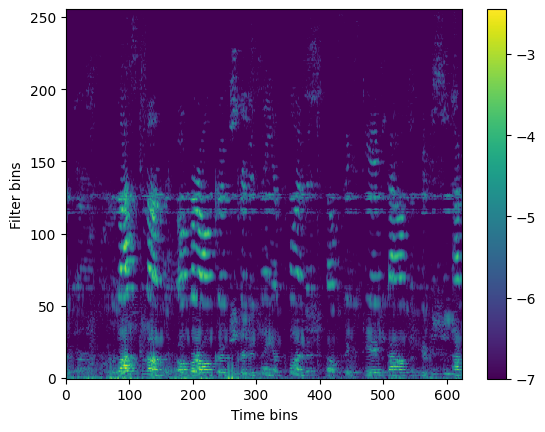

In [94]:
x_pad = F.pad(x, (T-1, 0), mode='circular')
x_fir = x_pad.unsqueeze(1)

filterbank = hybra.unsqueeze(1)

x_real = F.conv1d(x_fir, torch.fliplr(torch.real(filterbank)), stride=D)
x_imag = F.conv1d(x_fir, torch.fliplr(torch.imag(filterbank)), stride=D)
x_mag = x_real**2 + x_imag**2

plt.imshow(np.log10(x_mag.numpy()[0,:,:]), vmin=-7, aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Time bins')
plt.ylabel('Filter bins')

x_real = F.pad(x_real, (0, T-1), mode='circular')
x_imag = F.pad(x_imag, (0, T-1), mode='circular')

x_tilde_real = F.conv_transpose1d(x_real, torch.fliplr(torch.real(filterbank)), stride=D, padding=T-1).squeeze(0)
x_tilde_imag = F.conv_transpose1d(x_imag, torch.fliplr(torch.imag(filterbank)), stride=D, padding=T-1).squeeze(0)
x_tilde = (x_tilde_real + x_tilde_imag)*2*D

tensor(0.0957, dtype=torch.float64)


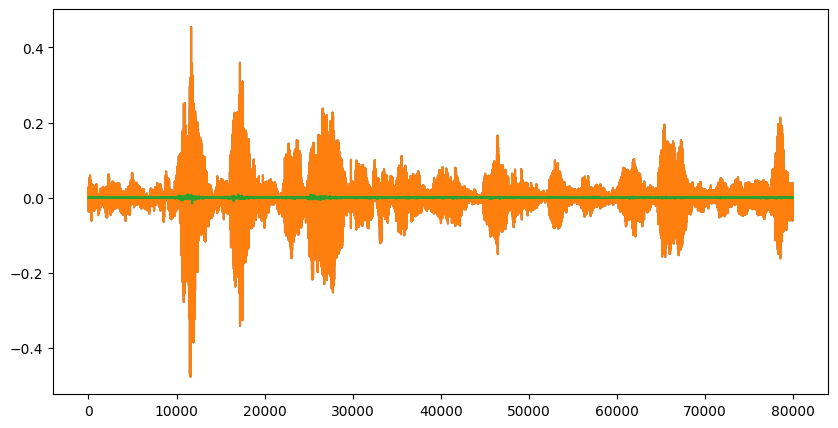

In [101]:
# set figsize
x_tilde = x_tilde[:,:N]

plt.figure(figsize=(10, 5))
plt.plot(x.T.numpy(), label='difference')
plt.plot(x_tilde.T.numpy(), label='reconstruction')
print(torch.linalg.norm(x-x_tilde[:,:N]))
plt.plot(x.T.numpy()-x_tilde.T.numpy())

In [147]:
N = 16000
D = 160
T = 512
J = 256

w = utils.random_filterbank(N, J, T, support_only=False) + 1j * utils.random_filterbank(N, J, T, support_only=False)
w_tight = fir_tightener5000(w, supp=T, D=D, eps=1.001)
A, B = frame_bounds_polyphase(w_tight, D)
# w_tight = can_tight_polyphase(w, D)
# A, B = frame_bounds_polyphase(w_tight, D)
print(B/A)

3.005158238088177
2.0434493779760823
1.6894594344149418
1.515381740430308
1.4079941950322106
1.3373005567341079
1.2878675007644727
1.2505536816610912
1.2215574100428235
1.1984255880261687
1.1795926241794352
1.1641137337458227
1.151651971399471
1.141032950098808
1.1318851641505965
1.1239055402612663
1.1168574181109747
1.1105885976262
1.1050830145359551
1.100150939177102
1.0956870026912315
1.0916238187712337
1.0879099225168516
1.084497786730082


KeyboardInterrupt: 

In [376]:
# N = 20
# D = 5
# T = 20
# J = 50

# w = utils.random_filterbank(N, J, T)
# A, B = frame_bounds(w, D=D)
# print(B/A)
# A, B = frame_bounds_polyphase(torch.fft.fft(w.T, dim=0), D=D)
# print(B/A)

In [12]:
N = 12
D = 2
T = 6
J = 6

w = utils.random_filterbank(N, J, T)
A, B = frame_bounds(w, D)
print(B/A)
#w_tight = fir_tightener3000(w, T, D, 1.01).real
#A, B = frame_bounds(w_tight, D)
#print(w)
W = fb_analysis(w, D)
S = (W.T @ W).numpy()
S_sqrt = torch.from_numpy(scipy.linalg.sqrtm(S).real)
S_inv_sqrt = torch.inverse(S_sqrt)
w_tight = (S_inv_sqrt @ w.T).T
A, B = frame_bounds(w_tight, D)
print(B/A)

14.979075060783199
6.87582679606989


In [55]:
N = 12
D = 2
T = 6
J = 2

#w_fir = torch.randint(1, 10, (J, T)).float()
#w = torch.cat([w_fir, torch.zeros(J, N-T)], dim=1)
w = utils.random_filterbank(N, J, T)
print(w)
w = fir_tightener3000(w, T, D, 1.01).real
w_fir = w[:, :T]

A, B = frame_bounds(w,D)
B/A

tensor([[ 0.6049, -0.1005,  0.1166,  0.1089, -0.1303,  0.4751,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.5046,  0.3401, -0.1003,  0.4633,  0.0775,  0.0175,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000]])
32.7690437607457
12.407327054874397
27.939924141738906
77.94440695846752
77.047040855007
497.3363227252201
9293.157871936284
48851.71352052517
95279.0221430437
11576206.573878227
30950938.38241655
82776733.60950613
-43929646.57078701
-43929646.57078701


-43929646.57078701

In [163]:
N = 12
D = 4
T = 12
J = 4

assert N % D == 0

x = torch.randint(1, 10, (1, N)).to(torch.complex64)

w = utils.random_filterbank(N, J, T, support_only=False)
w = torch.fft.fft(w.T, dim=0)
w = fir_tightener5000(w, T, D, 1.001)
w = torch.fft.ifft(w.T, dim=1)
w_fir = w[:, :T]

W = fb_analysis(w, D)
#V = fb_synthesis(w, D)

# analysis

y = (W @ x.T).reshape(J , N//D)
y_conv1d = F.conv1d(F.pad(x, (T-1, 0), mode='circular').unsqueeze(1),
                    torch.fliplr(w_fir).unsqueeze(1),
                    stride=D)
y_fft = torch.fft.ifft(torch.fft.fft(x) * torch.fft.fft(w))[:,::D]

# print(y)
# print(y_conv1d)
# print(y_fft)

# synthesis

z = (W.T @ y.reshape(J * N//D,1)).T
# D=1
# z_conv1d = F.conv_transpose1d(F.pad(y_conv1d, (0, T-1), mode='circular'), torch.fliplr(w_fir).unsqueeze(1), stride=D, padding=T-1)[0]
# D=2
# z_conv1d = F.conv_transpose1d(F.pad(y_conv1d, (0, T-2), mode='circular'), torch.fliplr(w_fir).unsqueeze(1), stride=D, padding=T-1)[0]
# D=3
# z_conv1d = F.conv_transpose1d(F.pad(y_conv1d, (0, T-3), mode='circular'), torch.fliplr(w_fir).unsqueeze(1), stride=D, padding=T-1)[0]
# D=4
# z_conv1d = F.conv_transpose1d(F.pad(y_conv1d, (0, T-4), mode='circular'), torch.fliplr(w_fir).unsqueeze(1), stride=D, padding=T-1)[0]

z_conv1d = F.conv_transpose1d(F.pad(y_conv1d, (0, T-4), mode='circular'), torch.fliplr(w_fir).unsqueeze(1), stride=D, padding=T-1)[0]


print(x)
print(z)
print(z_conv1d[:,:N])


1.0000010132795047


RuntimeError: Padding value causes wrapping around more than once.

1.677309545613117
1.4208601999633304
1.2867115562488196
1.2129975087098257
1.169003143719054
1.149044755124304
1.1339104979404477
1.122569514932212
1.1132474136488313
1.1053254077451735
1.0984922324762416
1.0925093330059974
1.0871998714109004
1.0824327956541437
1.0781119882336612
1.0741655315389014
1.0705393426661318
1.0671920981231473
1.064089875002017
1.0612062061820122
1.0585696888585143
1.0561046634679307
1.0537920138879862
1.051649596206579
1.049666430204916
1.047788086692473
1.0460094733586545
1.044323422292455
1.0427252195825616
1.041209096473898
1.0397702320996056
1.0384035725058411
1.0371043463023775
1.0358705305783926
1.0348748869606574
1.0339144780027085
1.0329884968949423
1.0320947442032777
1.0312715525558862
1.0305776735938095
1.0298977171420751
1.029230796677947
1.0285776664592732
1.027937764279288
1.0273112953259247
1.0266971408690946
1.026095986366785
1.0255071989158429
1.024931052587112
1.0243672224907787
1.0238143884534106
1.0232742119247586
1.022745074871864
1.022228

tensor(2.8466e-05)

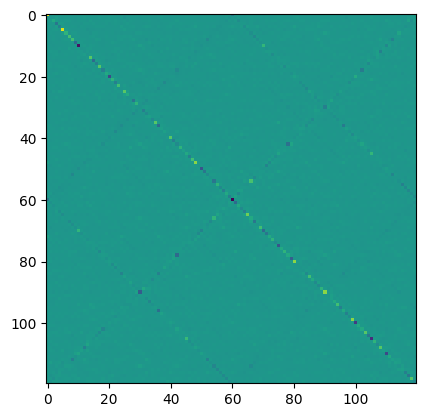

In [341]:
# frame operator

N = 120
D = 2
T = 60
J = 20

assert N % D == 0

w = utils.random_filterbank(N, J, T, support_only=False)
wf = fir_tightener5000(w, T, D, 1.001)
wt = torch.fft.ifft(wf.T, dim=1)

W = fb_analysis(wt, D)
S = (W.H @ W).to(torch.complex64)
DFT = torch.fft.fft(torch.eye(N))
S_hat = DFT @ S @ DFT.H

#S_hat2 = torch.fft.fft(W.H, dim=0) @ torch.conj(torch.fft.fft(W, dim=1))
S_hat2 = torch.fft.fft(W.H, dim=0) @torch.fliplr(torch.fft.fft(W, dim=1)).roll(1,-1)
# compute only every Dth side diagonal of S_hat


plt.imshow(torch.abs(S_hat)-torch.abs(S_hat2))
#plt.imshow(torch.abs(S_hat2))
torch.linalg.norm(S_hat-S_hat2)